<a href="https://colab.research.google.com/github/YAKUPA16/YAKUPA16/blob/main/docs/AI/text_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Movie Reviews with RNN

This text classification trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [4]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Tales from the Crypt: And All Through the House starts on Christmas Eve as Elizabeth (Mary Ellen Trainor) kills her husband Joseph (Marshall Bell), she drags his body outside ready to throw it down a well but while doing so misses an important news bulletin on the radio that says a homicidal maniac (Larry Drake) dressed as Santa Clause has escaped from a local mental asylum & has already killed several women with Elizabeth next on his list but she has other ideas & tries to turn the seemingly dangerous situation to her advantage...<br /><br />This Tales from the Crypt story was episode 2 from season 1, directed by the one of the show's regular executive producers Robert Zemeckis And All Through the House is a decent enough watch. The script by Fred Dekker was actually based on a story appearing in the comic 'The Vault of Horror' & was originally adapted to film as one episode from the Britsih horror anthology film Tales from the Crypt (1972) which starred Joan Collins as the

## Create the text encoder

In [10]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,  36,   2, ...,   0,   0,   0],
       [ 10,  26, 241, ...,   0,   0,   0],
       [  1,   5,   2, ...,   0,   0,   0]])

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Tales from the Crypt: And All Through the House starts on Christmas Eve as Elizabeth (Mary Ellen Trainor) kills her husband Joseph (Marshall Bell), she drags his body outside ready to throw it down a well but while doing so misses an important news bulletin on the radio that says a homicidal maniac (Larry Drake) dressed as Santa Clause has escaped from a local mental asylum & has already killed several women with Elizabeth next on his list but she has other ideas & tries to turn the seemingly dangerous situation to her advantage...<br /><br />This Tales from the Crypt story was episode 2 from season 1, directed by the one of the show's regular executive producers Robert Zemeckis And All Through the House is a decent enough watch. The script by Fred Dekker was actually based on a story appearing in the comic 'The Vault of Horror' & was originally adapted to film as one episode from the Britsih horror anthology film Tales from the Crypt (1972) which starred Joan Collins as t

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [16]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie. okay so nothing that exagerated just what you expect')
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[-0.01406678]


In [17]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
[-0.01406678]


Compile the Keras model to configure the training process:

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.5149 - loss: 0.6811 - val_accuracy: 0.5818 - val_loss: 0.5641
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.6981 - loss: 0.5317 - val_accuracy: 0.8120 - val_loss: 0.4380
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 53ms/step - accuracy: 0.8265 - loss: 0.3908 - val_accuracy: 0.8479 - val_loss: 0.3621
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.8521 - loss: 0.3455 - val_accuracy: 0.8448 - val_loss: 0.3477
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8622 - loss: 0.3275 - val_accuracy: 0.8562 - val_loss: 0.3326
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8660 - loss: 0.3205 - val_accuracy: 0.8281 - val_loss: 0.3547
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.8633 - loss: 0.3146 - val_accuracy: 0.8583 - val_loss: 0.3345
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.8688 - loss: 0.3073 -

In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.8559 - loss: 0.3203
Test Loss: 0.31932395696640015
Test Accuracy: 0.854640007019043


(0.0, 0.6633341163396835)

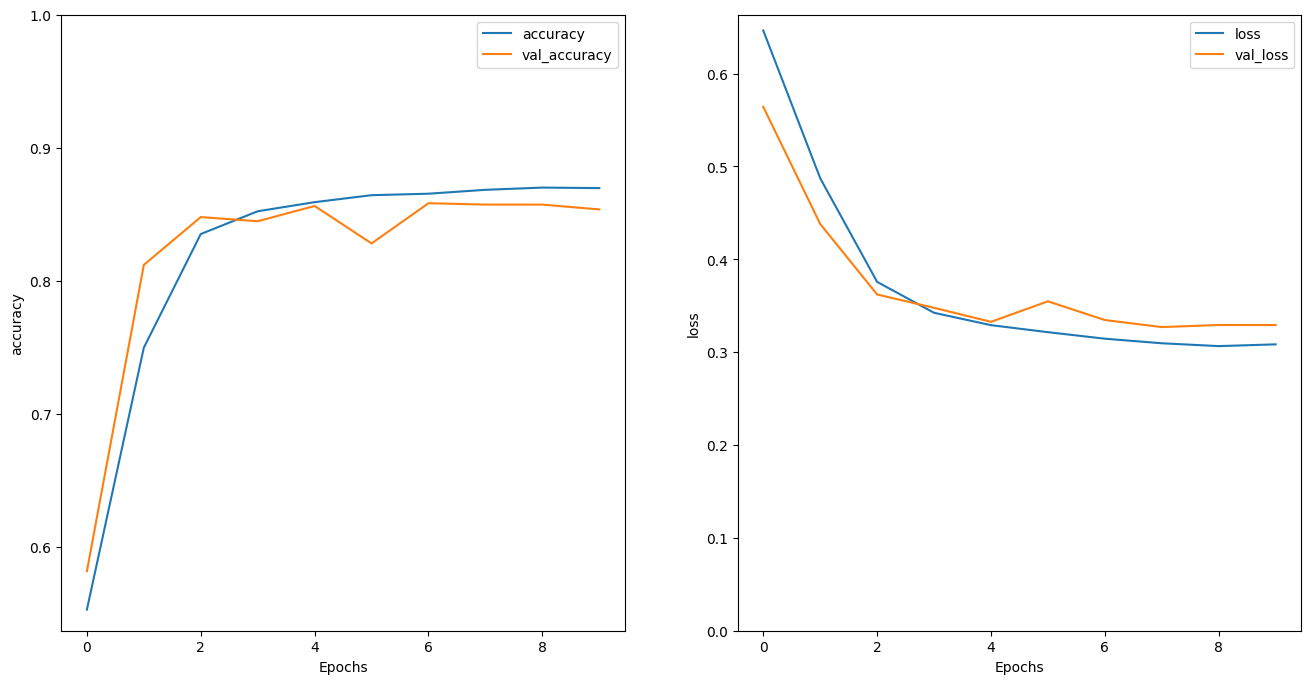

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [22]:
# Prepare true and predicted labels
y_true = []
y_pred = []

for batch in test_dataset:
    texts, labels = batch
    preds = model.predict(texts, verbose=0)

    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())  # Threshold = 0.5 for binary classification

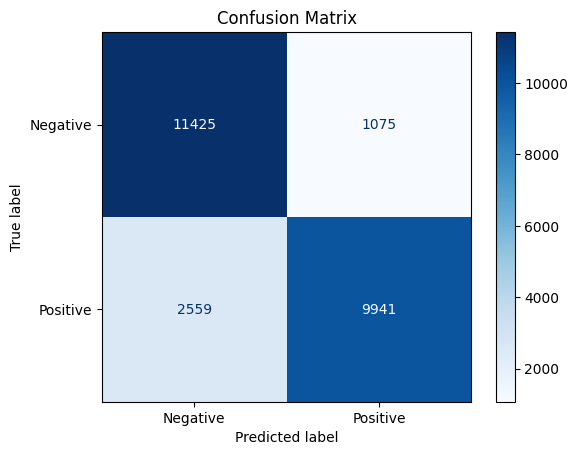

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Classification Report:

              precision    recall  f1-score   support

           0     0.8124    0.9131    0.8599       944
           1     0.9045    0.7961    0.8469       976

    accuracy                         0.8536      1920
   macro avg     0.8585    0.8546    0.8534      1920
weighted avg     0.8593    0.8536    0.8533      1920



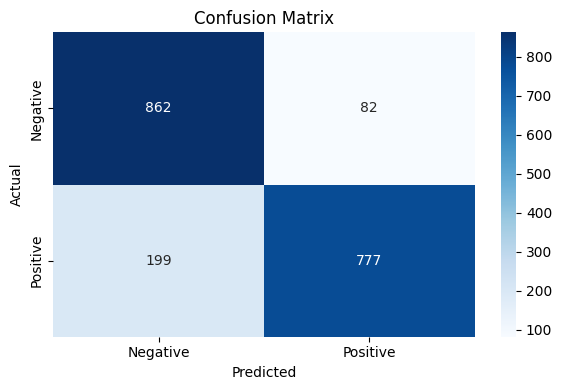

In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Limit the test dataset to a finite number of batches
y_true = []
y_pred = []

# Adjust this to match your dataset size (or set to len(test_dataset) if it's known)
for batch in test_dataset.take(30):  # take 30 batches only
    X_batch, y_batch = batch
    y_true.extend(y_batch.numpy())
    y_pred_probs = model.predict(X_batch, verbose=0)
    y_pred.extend((y_pred_probs > 0.5).astype(int).flatten())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

# Step 3: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [25]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

In [35]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 49s 106ms/step - accuracy: 0.5185 - loss: 0.6775 - val_accuracy: 0.8229 - val_loss: 0.4039
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - accuracy: 0.8309 - loss: 0.3860 - val_accuracy: 0.8458 - val_loss: 0.3727
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 208ms/step - accuracy: 0.8541 - loss: 0.3411 - val_accuracy: 0.8125 - val_loss: 0.3588
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 209ms/step - accuracy: 0.8549 - loss: 0.3335 - val_accuracy: 0.8479 - val_loss: 0.3286
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.8648 - loss: 0.3133 - val_accuracy: 0.8594 - val_loss: 0.3416
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - accuracy: 0.8573 - loss: 0.3275 - val_accuracy: 0.8578 - val_loss: 0.3447
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8655 - loss: 0.3115 - val_accuracy: 0.8250 - val_loss: 0.3573
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.8687 - loss: 0

In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8583 - loss: 0.3163
Test Loss: 0.31499171257019043
Test Accuracy: 0.8581200242042542


In [31]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
[[-1.9055272]]


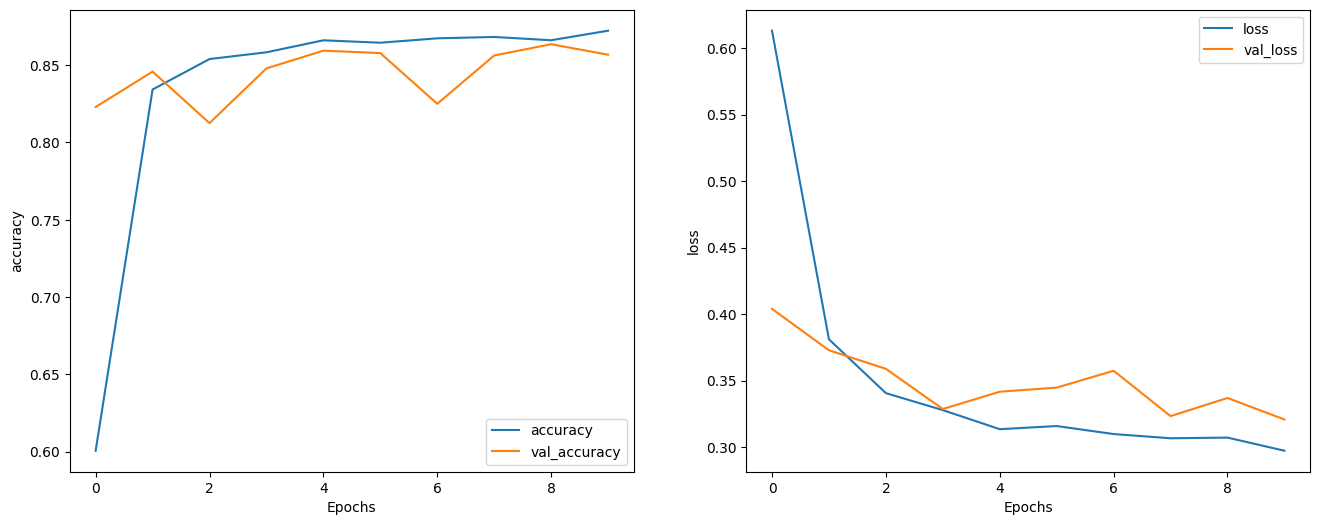

In [32]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

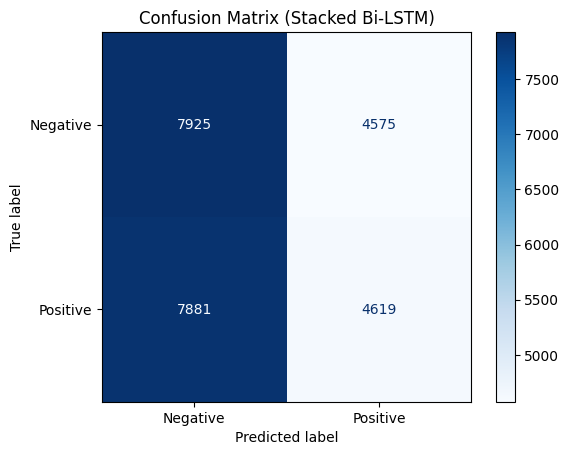

In [37]:
# Initialize lists
y_true = []
y_pred = []

# Batch prediction to avoid retracing
for texts, labels in test_dataset:
    logits = model.predict(texts, verbose=0)  # Outputs are logits (raw scores)
    preds = (logits > 0).astype(int).flatten()  # Since logits, use 0 threshold
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Create and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Stacked Bi-LSTM)")
plt.show()